# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithm that we use in this notebook is `Occlusion`. 
  
  **Note:** Please install the torchvision, PIL, and matplotlib packages.

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

##  Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval()

Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [3]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2021-02-26 00:49:04--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.72.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.72.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: '$HOME/.torch/models/imagenet_class_index.json.9'

     0K .......... .......... .......... ....                 100%  314K=0.1s

2021-02-26 00:49:05 (314 KB/s) - '$HOME/.torch/models/imagenet_class_index.json.9' saved [35363/35363]



In [4]:
with open("$HOME/.torch/models/imagenet_class_index.json") as json_data:
    idx_to_labels = json.load(json_data)
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [5]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('D:/Courses/Git/Captum/Images/swan.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
input

tensor([[[[-1.4329, -1.6727, -1.6213,  ..., -0.6794, -0.6109, -0.6965],
          [-1.4500, -1.6042, -1.2788,  ..., -0.8164, -0.7308, -0.7822],
          [-1.4843, -1.5014, -1.0904,  ..., -1.0048, -0.8335, -0.8507],
          ...,
          [-0.5767, -0.6109, -0.5767,  ...,  0.1768,  0.1939,  0.1426],
          [-0.5424, -0.4911, -0.4911,  ..., -0.0458,  0.0741,  0.0227],
          [-0.3712, -0.2684, -0.2684,  ...,  0.1768, -0.0116, -0.1143]],

         [[-1.3354, -1.5280, -1.4755,  ..., -0.3725, -0.1975, -0.1975],
          [-1.3529, -1.4755, -1.1429,  ..., -0.5651, -0.3725, -0.2325],
          [-1.3704, -1.3704, -0.9678,  ..., -0.7927, -0.5301, -0.2850],
          ...,
          [-0.3200, -0.3725, -0.3550,  ...,  0.4503,  0.4678,  0.4678],
          [-0.3025, -0.2675, -0.2675,  ...,  0.2227,  0.3452,  0.3452],
          [-0.1099, -0.0049, -0.0224,  ...,  0.4153,  0.2577,  0.1877]],

         [[-1.3513, -1.5953, -1.5953,  ..., -1.1944, -1.2816, -1.7173],
          [-1.4036, -1.5779, -

Predict the class of the input image

In [6]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: king_penguin ( 0.6036961674690247 )


## Occlusion based attribution

We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [17]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

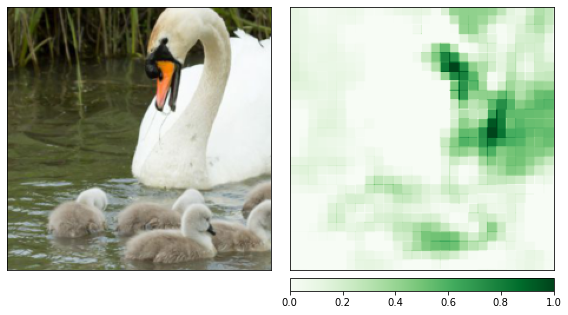

In [18]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


The upper part of the goose, espectially the beak, seems to be the most critical for the model to predict this class. Since it highly resembles penguin's head shape and beak, the swan is wrongly interpreted as penguin.

We can verify this further by occluding the image using a larger sliding window:

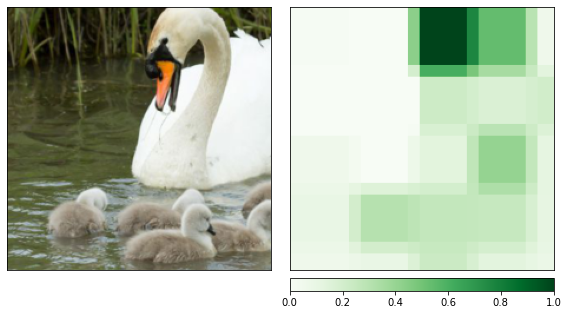

In [19]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )